# Initialization
**This section needs to be executed to execute the following cells.**

We use a simplified version of ERIS where the only metrics computed is the one "shared" by both ERIS and Guerra et al.'s method, that is the antagonism matrix.

In [56]:
source("eris_matrix_complexity_analysis.R")
source("eris_iterative_complexity_analysis.R")

if (!require("glue")) install.packages("glue"); library(glue)
if (!require("ggplot2")) install.packages("ggplot2"); library(ggplot2)

Loading required package: ggplot2



In [63]:
community_algorithm <- cluster_louvain

# Graph Generation
**This section explains how the graphs were generated.**

## Parameters

In [11]:
nb_communities_in_graphs <- 3
decreasing_step_edges <- 1000

path_to_graphs <- "graphs/"

## Method

**Step 1:** The first graph used is built from real data harvested from Twitter.

In [61]:
g_rt <- read_graph("g_rt.gml", "gml")
print("Graph Loaded")

[1] "Graph Loaded"


**Step 2**: We remove vertices to keep only users in the *nb_communities_in_graphs* most important communities.

In [10]:
res_community_detection <- as.undirected(g_rt, mode = "collapse") %>% community_algorithm()
V(g_rt)$community <- membership(res_community_detection)
g_rt <- delete_vertices(g_rt, 
                        V(g_rt)[which(!(V(g_rt)$community %in% 
                                        names(sort(sizes(res_community_detection), decreasing = TRUE)[1:nb_communities_in_graphs])))])

**Step 3**: We serialize the first graph.

In [13]:
write_graph(g_rt, sprintf("%sg0_%s_%s.gml", path_to_graphs, vcount(g_rt), ecount(g_rt)), "gml")

**Step 4:** We reproduce the previous steps while reducing the graph size.

In [14]:
g <- g_rt
g_ecount <- ecount(g_rt)
i <- 1
while (g_ecount > decreasing_step_edges) {
    # Reduce the graph size by removing edges and then isolated vertices.
    g <- delete_edges(g, sample(E(g), decreasing_step_edges))
    g <- delete.vertices(g, which(degree(g, V(g), mode = "all") == 0))
    
    # Reproduce steps 2 and 3.
    res_community_detection <- as.undirected(g, mode = "collapse") %>% community_algorithm()
    V(g)$community <- membership(res_community_detection)
    g <- delete_vertices(g, 
                         V(g)[which(!(V(g)$community %in% 
                                        names(sort(sizes(res_community_detection), decreasing = TRUE)[1:nb_communities_in_graphs])))])
    
    g_ecount <- ecount(g)
    write_graph(g, sprintf("%sg%s_%s_%s.gml", path_to_graphs, i, vcount(g), g_ecount), "gml")
    i <- i + 1
} 

# Execution Time Measurement
**This section explains how the execution times are measured.**

In [19]:
path_to_studied_graphs <- "graphs_rcis/"
path_to_results <- "times/"

**Step 1**: We load the graphs.

In [16]:
graph_files <- list.files(path_to_studied_graphs)

**Step 2:** Graphs are reordered according to their number of vertices.

In [17]:
names(graph_files) <- as.numeric(unname(
    sapply(graph_files, function(x) gsub("g", "", unlist(strsplit(x, "_"))[[1]]))
))
graph_files <- graph_files[order(-as.numeric(names(graph_files)))]

**Step 3:** Execution times are measured.

In [31]:
lapply(graph_files, function(file) {
    g <- read_graph(paste(path_to_studied_graphs, file, sep = ""), "gml")
    eris_parameters <- compute_polarization_metrics_graph(g)
    time <- system.time(compute_polarization_metrics(eris_parameters$Ma, eris_parameters$Mc))
    write.table(
        t(data.frame(unname(time[1:3]))), 
        sprintf('%stimes_%s.csv', path_to_results, "matrix_eris"), 
        append = T, 
        sep = ';', 
        row.names = FALSE, 
        col.names = FALSE )
    time
})

$`12`
   user  system elapsed 
  0.033   0.000   0.033 

$`11`
   user  system elapsed 
  0.034   0.000   0.034 

$`10`
   user  system elapsed 
  0.035   0.000   0.035 

$`9`
   user  system elapsed 
  0.037   0.000   0.038 

$`8`
   user  system elapsed 
  0.062   0.000   0.061 

$`7`
   user  system elapsed 
  0.085   0.000   0.086 

$`6`
   user  system elapsed 
  0.112   0.000   0.113 

$`5`
   user  system elapsed 
  0.142   0.000   0.142 

$`4`
   user  system elapsed 
  0.194   0.000   0.194 

$`3`
   user  system elapsed 
  0.313   0.000   0.313 

$`2`
   user  system elapsed 
  0.805   0.000   0.805 

$`1`
   user  system elapsed 
  1.649   0.000   1.650 

$`0`
   user  system elapsed 
  2.369   0.036   2.406 


In [37]:
lapply(graph_files, function(file) {
    g <- read_graph(paste(path_to_studied_graphs, file, sep = ""), "gml")
    eris_parameters <- graph_polarization(g, V(g)$community)
    time <- system.time(polarization(eris_parameters$adjacency_list, eris_parameters$community_membership, eris_parameters$adjacency_matrix))
    write.table(
        t(data.frame(unname(time[1:3]))), 
        sprintf('%stimes_%s.csv', path_to_results, "iterative_eris"), 
        append = T, 
        sep = ';', 
        row.names = FALSE, 
        col.names = FALSE )
    time
})

# Results
**This section generates vizualisations of the results.**

In [49]:
path_to_csv_results <- "times_rcis/"

## Result Loading

We load the execution times of guerra et al.'s method and of the iterative version of ERIS.

In [50]:
times_guerra <- read.csv(sprintf("%stimes_v0.csv", path_to_csv_results), header = FALSE, sep = ";")
times_iterative <- read.csv(sprintf("%stimes_v1.csv", path_to_csv_results), header = FALSE, sep = ";")

Same for the matrix computation based version of ERIS. We launched multiple analyzes to get mean values.

In [51]:
times_matrix1 <- read.csv(sprintf("%stimes_v2.csv", path_to_csv_results), header = FALSE, sep = ";")
times_matrix2 <- read.csv(sprintf("%stimes_v2_2.csv", path_to_csv_results), header = FALSE, sep = ";")
times_matrix3 <- read.csv(sprintf("%stimes_v2_3.csv", path_to_csv_results), header = FALSE, sep = ";")
times_matrix4 <- read.csv(sprintf("%stimes_v2_4.csv", path_to_csv_results), header = FALSE, sep = ";")
times_matrix5 <- read.csv(sprintf("%stimes_v2_5.csv", path_to_csv_results), header = FALSE, sep = ";")
times_matrix6 <- read.csv(sprintf("%stimes_v2_6.csv", path_to_csv_results), header = FALSE, sep = ";")

times_matrix <- data.frame(
                V1 = rowMeans(cbind(times_matrix1$V1, times_matrix2$V1, times_matrix3$V1, times_matrix4$V1, times_matrix5$V1, times_matrix6$V1), na.rm=TRUE),
                V2 = rowMeans(cbind(times_matrix1$V2, times_matrix2$V2, times_matrix3$V2, times_matrix4$V2, times_matrix5$V2, times_matrix6$V2), na.rm=TRUE),
                V3 = rowMeans(cbind(times_matrix1$V3, times_matrix2$V3, times_matrix3$V3, times_matrix4$V3, times_matrix5$V3, times_matrix6$V3), na.rm=TRUE))

In [52]:
graphs_names <- list.files(path_to_studied_graphs)
vcounts <- sort(as.numeric(unname(sapply(graphs_names, function(x) gsub(".gml", "", unlist(strsplit(x, "_"))[[2]])))))
ecounts <- sort(as.numeric(unname(sapply(graphs_names, function(x) gsub(".gml", "", unlist(strsplit(x, "_"))[[3]])))))

In [54]:
times <- data.frame(
    id = sequence(13), 
    vcount = vcounts, 
    ecount = ecounts, 
    guerra = times_guerra$V1, 
    iterative = times_iterative$V1, 
    matrix = times_matrix$V1)
print(times)

   id vcount  ecount       guerra iterative     matrix
1   1    684     681 1.539918e+00     0.052 0.04850000
2   2   1669    1686 4.171216e+00     0.174 0.04200000
3   3   2654    2710 7.307148e+00     0.269 0.03650000
4   4   3912    4127 1.208863e+01     0.529 0.03800000
5   5  20604   29390 2.056944e+02     4.105 0.06300000
6   6  35516   74217 7.002338e+02     5.488 0.08583333
7   7  53780  106975 1.558961e+03    10.472 0.11250000
8   8  72054  159127 3.187851e+03    23.152 0.14433333
9   9 106896  229541 7.549220e+03    54.381 0.22850000
10 10 180981  433222 2.591778e+04   283.963 0.37933333
11 11 373997 1164409 1.694701e+05  2900.432 0.83000000
12 12 673887 2535423 7.555002e+05  9947.737 1.70100000
13 13 904458 4427838 1.528389e+06 32070.872 2.56050000


## Plots

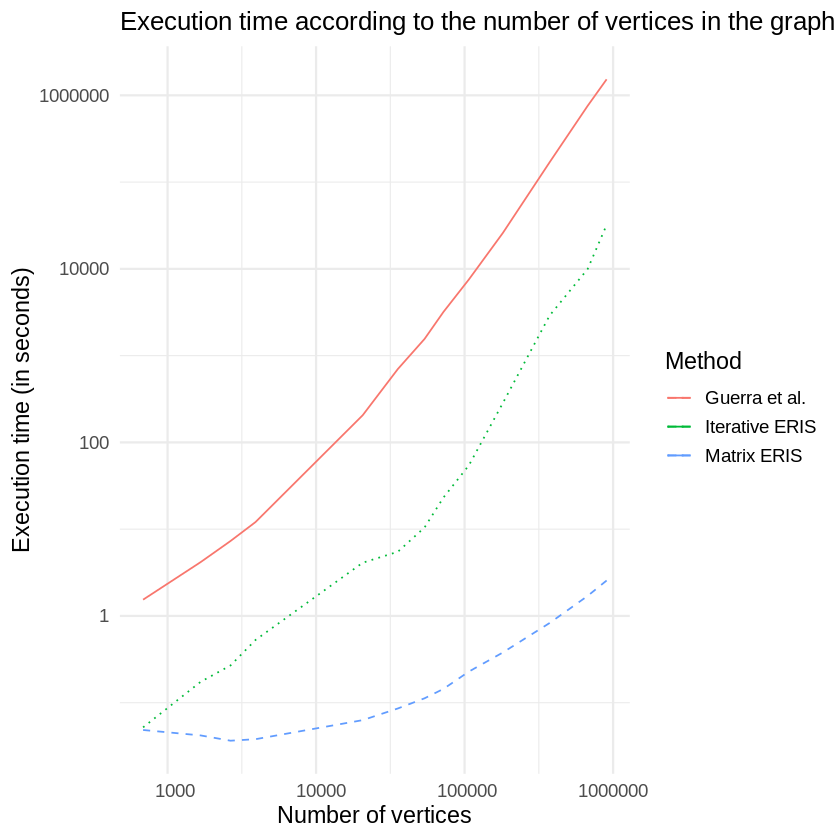

In [57]:
no_scientific = function(x) format(x, scientific = FALSE)
ggplot(times, aes(vcount)) + 
  geom_line(aes(y = guerra, group = 1, colour = "Guerra et al.")) + 
  geom_line(aes(y = iterative, group = 2, colour = "Iterative ERIS"), linetype="dotted") +
  geom_line(aes(y = matrix, group = 3, colour = "Matrix ERIS"), linetype="dashed") +
  scale_x_continuous(trans='log10', labels = no_scientific) +
  scale_y_continuous(trans='log10', labels = no_scientific) +
  ggtitle("Execution time according to the number of vertices in the graph") +
  xlab("Number of vertices") + ylab("Execution time (in seconds)") + labs(colour = "Method") +
  theme_minimal(base_size=14) +
  theme(plot.title = element_text(size = 15.5)) 

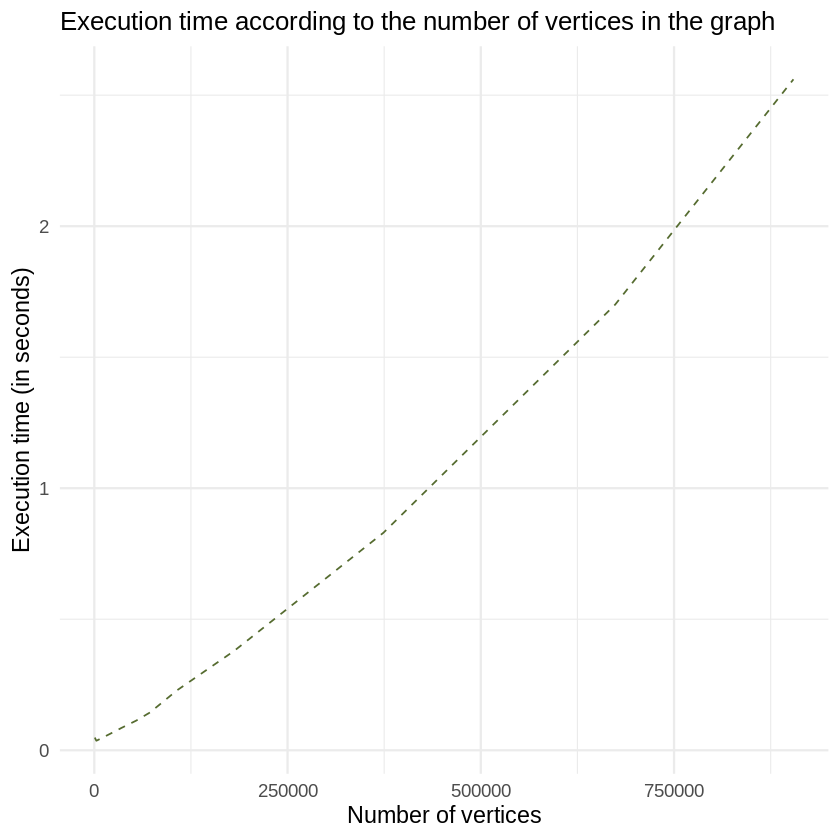

In [60]:
ggplot(times, aes(x=vcount, y=matrix)) + 
  geom_line(aes(y = matrix), color="darkolivegreen", linetype="dashed") +
  ggtitle("Execution time according to the number of vertices in the graph") +
  xlab("Number of vertices") + ylab("Execution time (in seconds)") + labs(colour = "Method")  +
  theme_minimal(base_size=14) +
  theme(plot.title = element_text(size = 15.5)) 